## Kaggle Competition: Histopathologic Cancer Detection

In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

In [21]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from src.data import train_test_split, get_image_dataloaders, display_image_batch
from src.model import SimpleCNNModel, get_resnet18, save_model, load_model
from src.train import train_model, validate_model

### Prep-processing; only needs to be run once

Assumes there is a directory 'data' with a sub-directory 'train_all' that contains the unzipped 'train.zip'

In [ ]:
train_test_split('data/train_labels.csv', 'data')

## Experiment 1 -  Simple, hand-crafted CNN model

### Load the data

In [46]:
DATA_DIR = 'data/'

data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    'validate': transforms.Compose([
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
}

dataloader_params = {
    "batch_size": 256,  # Increasing this will yield a CUDA Out-Of-Memory exception
    "shuffle": True,
    "num_workers": 8,
}
dataloaders = get_image_dataloaders(DATA_DIR, transforms=data_transforms, **dataloader_params)

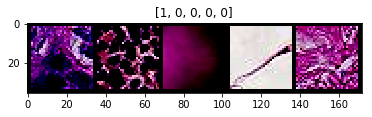

In [47]:
# Display training data

inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs[:5])
display_image_batch(out, title=classes[:5].tolist())

### Prepare the model and training conditions

In [73]:
model_ft = SimpleCNNModel()

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# Display model layers
model_ft

SimpleCNNModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)

#### Optional: Load a previously trained model from disk


In [72]:
model_ft = load_model(model_ft, 'SimpleCNNModel')

### Train the model

In [74]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

Epoch 0/2
----------


Epoch: 0 Training Batch: 50 Loss: 0.6852685820822623 Acc: 0.5964307598039216
Epoch: 0 Training Batch: 100 Loss: 0.6830870385217195 Acc: 0.597965655940594
Epoch: 0 Training Batch: 150 Loss: 0.6812330989648174 Acc: 0.5988203642384106
Epoch: 0 Training Batch: 200 Loss: 0.6798841816868948 Acc: 0.5985696517412935
Epoch: 0 Training Batch: 250 Loss: 0.6792528170988379 Acc: 0.5965668575697212
Epoch: 0 Training Batch: 300 Loss: 0.6784444425589222 Acc: 0.5961119186046512
Epoch: 0 Training Batch: 350 Loss: 0.6774462335809344 Acc: 0.5967214209401709
Epoch: 0 Training Batch: 400 Loss: 0.6766588152792685 Acc: 0.5968477244389028
Epoch: 0 Training Batch: 450 Loss: 0.6762607619661978 Acc: 0.5961405210643016
Epoch: 0 Training Batch: 500 Loss: 0.6756446501927937 Acc: 0.5962216192614771
Epoch: 0 Training Batch: 550 Loss: 0.6750739621380496 Acc: 0.5962383734119783
Epoch: 0 Training Batch: 600 Loss: 0.6746296196332986 Acc: 0.5960638519134775
Epoch: 0 Training Batch: 650 Loss: 0.6742888717424302 Acc: 0.59566

validate Loss: 0.6681937670820287 Acc: 0.5927397384671268

Epoch 1/2
----------


Epoch: 1 Training Batch: 50 Loss: 0.6664063299403471 Acc: 0.5955882352941176
Epoch: 1 Training Batch: 100 Loss: 0.666776966340471 Acc: 0.5935566212871287
Epoch: 1 Training Batch: 150 Loss: 0.6646994833914649 Acc: 0.5964145281456954
Epoch: 1 Training Batch: 200 Loss: 0.6646392401771166 Acc: 0.5949549129353234
Epoch: 1 Training Batch: 250 Loss: 0.664177130180526 Acc: 0.5943102589641435
Epoch: 1 Training Batch: 300 Loss: 0.6626289684907146 Acc: 0.5958004568106312
Epoch: 1 Training Batch: 350 Loss: 0.661629665271509 Acc: 0.595641915954416
Epoch: 1 Training Batch: 400 Loss: 0.6606335706841618 Acc: 0.5955423940149626
Epoch: 1 Training Batch: 450 Loss: 0.6594287638125028 Acc: 0.5954216324833703
Epoch: 1 Training Batch: 500 Loss: 0.6579787846572861 Acc: 0.5956758358283433
Epoch: 1 Training Batch: 550 Loss: 0.6562399174037733 Acc: 0.5959973343920145
Epoch: 1 Training Batch: 600 Loss: 0.654621170185965 Acc: 0.5958558652246256
Epoch: 1 Training Batch: 650 Loss: 0.6528765747807176 Acc: 0.595274097

validate Loss: 0.6187192785319873 Acc: 0.5927170359607701

Epoch 2/2
----------


Epoch: 2 Training Batch: 50 Loss: 0.6133630415972542 Acc: 0.6008731617647058
Epoch: 2 Training Batch: 100 Loss: 0.6073595562783798 Acc: 0.616878094059406
Epoch: 2 Training Batch: 150 Loss: 0.603320434788205 Acc: 0.6318553394039735
Epoch: 2 Training Batch: 200 Loss: 0.5983038402315396 Acc: 0.6468827736318408
Epoch: 2 Training Batch: 250 Loss: 0.5917547694240434 Acc: 0.6615102091633466
Epoch: 2 Training Batch: 300 Loss: 0.5864890491051531 Acc: 0.67218646179402
Epoch: 2 Training Batch: 350 Loss: 0.582013673761971 Acc: 0.6819021545584045
Epoch: 2 Training Batch: 400 Loss: 0.5785106445042569 Acc: 0.6893313591022444
Epoch: 2 Training Batch: 450 Loss: 0.5758377710757921 Acc: 0.6948101441241685
Epoch: 2 Training Batch: 500 Loss: 0.5721399505100326 Acc: 0.700778131237525
Epoch: 2 Training Batch: 550 Loss: 0.5687284165090745 Acc: 0.7056559097096189
Epoch: 2 Training Batch: 600 Loss: 0.5651340378501054 Acc: 0.7101185524126455
Epoch: 2 Training Batch: 650 Loss: 0.5619698830189244 Acc: 0.7137096774

validate Loss: 0.5222707335034414 Acc: 0.7588766799854704

Training complete in 1m 41s
Best val Acc: 0.758877


### Optional, save the model

In [75]:
save_model(model_ft, 'SimpleCNNModel')

### Validate the model

In [85]:
inputs, labels, preds = validate_model(model_ft, dataloaders['train'], num_batches=5)

In [87]:
true_positives = inputs[(preds == labels) & (preds == 1)]
false_positives = inputs[(preds > labels)]
true_negatives = inputs[(preds == labels) & (preds == 0)]
false_negatives = inputs[(preds < labels)]

cm = confusion_matrix(labels.numpy(), preds.numpy())
# Normalize the cells so that we display percentages instead of counts
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

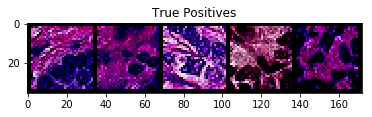

In [88]:
if len(true_positives):
    display_image_batch(torchvision.utils.make_grid(true_positives[:5]), title="True Positives")

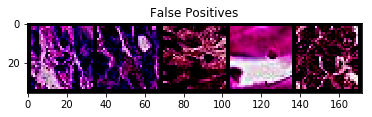

In [89]:
if len(false_positives):
    display_image_batch(torchvision.utils.make_grid(false_positives[:5]), title="False Positives")

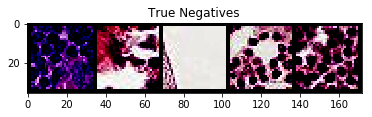

In [90]:
if len(true_negatives):
    display_image_batch(torchvision.utils.make_grid(true_negatives[:5]), title="True Negatives")

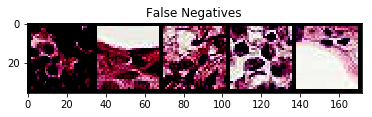

In [91]:
if len(false_negatives):
    display_image_batch(torchvision.utils.make_grid(false_negatives[:5]), title="False Negatives")

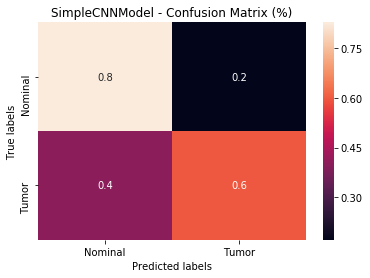

In [92]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt = '.1f', ax=ax)
ax.set_title('SimpleCNNModel - Confusion Matrix (%)')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Nominal', 'Tumor'])
ax.yaxis.set_ticklabels(['Nominal', 'Tumor', ]);

In [93]:
false_positive_rate, true_positive_rate, threshold = roc_curve(labels.numpy(), preds.numpy())
area_under_curve = auc(false_positive_rate, true_positive_rate)

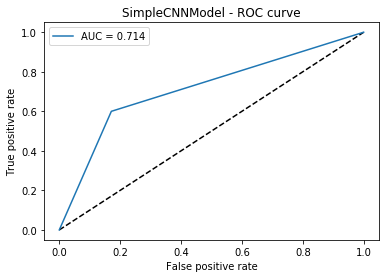

In [94]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('SimpleCNNModel - ROC curve')
plt.legend(loc='best')

## Experiment 2 - ResNet 18

### Resnet18: Prepare the model and training conditions

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),  # The input size of Resnet18
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # TODO calculate the dataset per-channel mean and stddev
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validate': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

dataloader_params = {
    "batch_size": 256,  # Increasing this will yield a CUDA Out-Of-Memory exception
    "shuffle": True,
    "num_workers": 8,
}
dataloaders = get_image_dataloaders(DATA_DIR, transforms=data_transforms, **dataloader_params)

### Prepare the model and training conditions

In [ ]:
model_ft = get_resnet18()

#criterion = nn.CrossEntropyLoss()
#criterion = nn.BCEWithLogitsLoss()
criterion = nn.BCELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.1)

# Display model layers
model_ft

#### Optional: Load a previously trained model from disk


In [ ]:
model_ft = load_model(model_ft, 'resnet18')

### Train the model

In [ ]:
model_ft = train_model(model_ft, dataloaders, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10)

### Optional, save the model

In [ ]:
save_model(model_ft, 'resnet18')

### Validate the model

In [ ]:
inputs, labels, preds = validate_model(model_ft, dataloaders['validate'], num_batches=5)

In [ ]:
true_positives = inputs[(preds == labels) & (preds == 1)]
false_positives = inputs[(preds > labels)]
true_negatives = inputs[(preds == labels) & (preds == 0)]
false_negatives = inputs[(preds < labels)]

cm = confusion_matrix(labels.numpy(), preds.numpy())
# Normalize the cells so that we display percentages instead of counts
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
if len(true_positives):
    display_image_batch(torchvision.utils.make_grid(true_positives[:5]), title="True Positives")

In [ ]:
if len(false_positives):
    display_image_batch(torchvision.utils.make_grid(false_positives[:5]), title="False Positives")

In [ ]:
if len(true_negatives):
    display_image_batch(torchvision.utils.make_grid(true_negatives[:5]), title="True Negatives")

In [ ]:
if len(false_negatives):
    display_image_batch(torchvision.utils.make_grid(false_negatives[:5]), title="False Negatives")

In [ ]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt = '.1f', ax=ax)
ax.set_title('ResNet18 - Confusion Matrix (%)')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.xaxis.set_ticklabels(['Nominal', 'Tumor'])
ax.yaxis.set_ticklabels(['Nominal', 'Tumor', ]);

In [ ]:
false_positive_rate, true_positive_rate, threshold = roc_curve(labels.numpy(), preds.numpy())
area_under_curve = auc(false_positive_rate, true_positive_rate)

In [ ]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ResNet18 - ROC curve')
plt.legend(loc='best')